# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

## Experiment Summary

For this case study, 10 experiments have been done as mentioned below.
- Experiment 1: Model with 3 Conv3d  + Batch Normalisation + Pooling layers
- Experiment 2: Increasing Layer Set on Experiment 1
- Experiment 3: Increasing Dense Layer Kernels on Experiment 2
- Experiment 4: Increasing batch size on Experiment3
- Experiment 5: Increasing learning rate on Experiment 4
- Experiment 6: Increasing epochs to 40 on Experiment 3
- Experiment 7: CNN+RNN with MobileNetV2 Transfer Learning + GRU layers
- Experiment 8: Decreasing the number of output neurons from MobileNet on Experiment 7
- Experiment 9: Decreasing batch size and learning rate, increasing GRU Kernels


From the experiments done below, **the best chosen model is Experiment 1** which has best training and validation accuracy of about 76% each

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(30)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, BatchNormalization, MaxPooling3D, GlobalAveragePooling3D, Conv3D, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
# setting frame indexes to be used for training
img_idx = range(4,22)

batch_size = 32
# each frame width set to be 120x120 for CNN3D since frames are of sizes 120x160 and 360x360
frame_width =120
frame_height=120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size, transfer_learning=False):
    # print( 'Source path = ', source_path, '; batch size =', batch_size)
    global img_idx  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t) // batch_size 
        for batch in range(num_batches): # we iterate over the number of batches    

            x, y, z = len(img_idx), frame_width, frame_height

            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if transfer_learning:
                        # MobileNetV2 proprocessing function
                        image = preprocess_input(image)
                        
                    #crop the images and resize them
                    image_width, image_height = image.shape[0], image.shape[1]
                    top_offset, left_offset, bottom_offset, right_offset = int(image_height / 2) -60, int(image_width/2) -60, int(image_height / 2) +60, int(image_width / 2) +60
                    image = image[left_offset : right_offset, top_offset : bottom_offset, :]
                    
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(frame_width, frame_height)).astype(np.float32)
                    else:
                        image = resize(image,(frame_width, frame_height)).astype(np.float32)
                    # Normalizing the image in respective channels
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) / np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) / np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) / np.std(image[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        count = len(t) % batch_size

        if count != 0:
            # write the code for the remaining data points which are left after full batches
            batch_labels = np.zeros((count,5)) # batch_labels is the one hot representation of the output
            batch_data = np.zeros((count,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            
            for folder in range(count): # iterate over the count
                imgs = os.listdir(source_path+'/'+ t[folder + (batch_size * num_batches)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if transfer_learning:
                        # MobileNetV2 proprocessing function
                        image = preprocess_input(image)
                    
                    #crop the images and resize them
                    image_width, image_height = image.shape[0], image.shape[1]
                    top_offset, left_offset, bottom_offset, right_offset = int(image_height / 2) -60, int(image_width/2) -60, int(image_height / 2) +60, int(image_width / 2) +60
                    image = image[left_offset : right_offset, top_offset : bottom_offset, :]

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(frame_width, frame_height)).astype(np.float32)
                    else:
                        image = resize(image,(frame_width, frame_height)).astype(np.float32)
                    
                    # Normalizing the image in respective channels
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) / np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) / np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) / np.std(image[:,:,2])
                        
                batch_labels[folder, int(t[folder + (batch_size * num_batches)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [6]:
'''
Function to display the training vs validation accuracy and training vs validation losses over epochs
'''
def plot_curves(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(history.params['epochs'])

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [7]:
# transfer_learning parameter not given since CNN3D wont use it
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [8]:
model_name = 'model_init_cnn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

In [9]:
# Defining checkpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# Defining early stop callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, mode='min')
# defnining reduceLR callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0, min_lr=0.0001)
callbacks_list = [checkpoint, LR]

In [10]:

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [11]:
# Input shape = (18, 120, 120, 3)
input_shape = (len(img_idx), frame_width, frame_height, 3)

## Experiment 1

In [12]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))


In [13]:
# Using SGD optimizer with default LR=0.01
optimiser = keras.optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 120, 120, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 18, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 60, 60, 8)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 60, 60, 16)     64        
_________________________________________________________________
activation_1 (Activation)    (None, 9, 60, 60, 16)     0

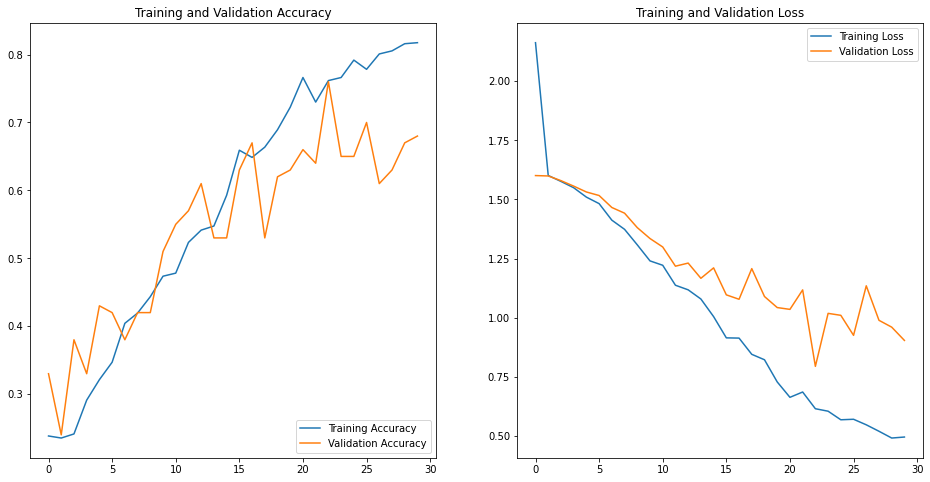

In [14]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observation**

the model is performing well as both training and validation accuracy is increasing steadily. We will try adding more layers to extract more features

## Experiment 2: Increasing Layer Set

In [15]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Increased layer set
model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [16]:
# Using SGD optimizer with default LR=0.01
optimiser = keras.optimizers.SGD() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 18, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 120, 120, 8)   32        
_________________________________________________________________
activation_3 (Activation)    (None, 18, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 60, 60, 8)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 9, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 60, 60, 16)     64        
_________________________________________________________________
activation_4 (Activation)    (None, 9, 60, 60, 16)    

In [17]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.0864 - categorical_accuracy: 0.2051
Epoch 00001: val_loss did not improve from 0.79429
21/21 [==============================] - 70s 3s/step - loss: 2.0864 - categorical_accuracy: 0.2051 - val_loss: 1.6023 - val_categorical_accuracy: 0.2000
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6178 - categorical_accuracy: 0.2247
Epoch 00002: val_loss did not improve from 0.79429
21/21 [==============================] - 68s 3s/step - loss: 1.6178 - categorical_accuracy: 0.2247 - val_loss: 1.6043 - val_categorical_accuracy: 0.2600
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6071 - categorical_accuracy: 0.2172
Epoch 00003: val_loss did not improve from 0.79429

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
21/21 [==============================] - 70s 3s/step - loss: 1.6071 - categorical_accuracy: 0.2172 - val_loss: 1.6056 - val_categorical_accurac

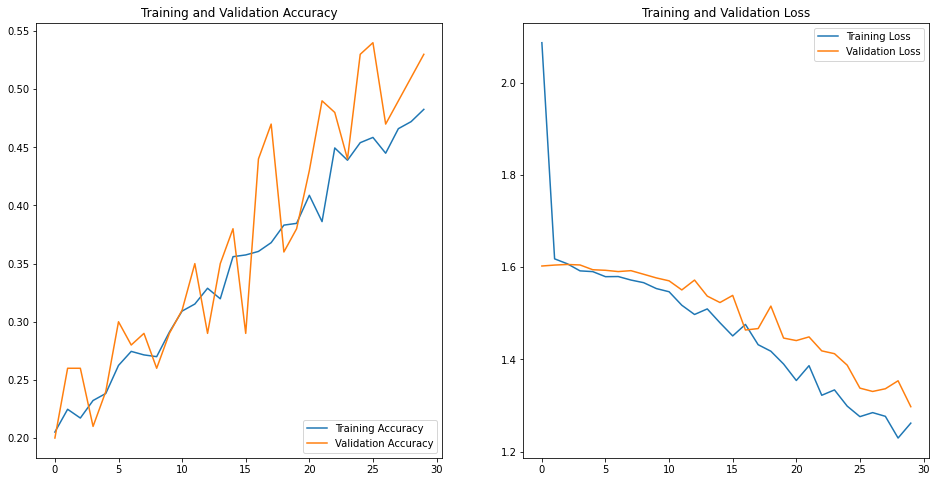

In [18]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

After adding more layers, the number of parameters dropped sharply. Hence the model is now underfitting. Both the training and validation accuracy are now under 0.55. 
So we shall add more Kernels in dense layer of this model and see the output.

## Experiment 3: Increasing Dense Layer Kernels

In [19]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [20]:
optimiser = keras.optimizers.SGD() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 18, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 18, 120, 120, 8)   32        
_________________________________________________________________
activation_7 (Activation)    (None, 18, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 9, 60, 60, 8)      0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 9, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 9, 60, 60, 16)     64        
_________________________________________________________________
activation_8 (Activation)    (None, 9, 60, 60, 16)    

In [21]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.0610 - categorical_accuracy: 0.2278
Epoch 00001: val_loss did not improve from 0.79429
21/21 [==============================] - 71s 3s/step - loss: 2.0610 - categorical_accuracy: 0.2278 - val_loss: 1.6013 - val_categorical_accuracy: 0.2400
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6268 - categorical_accuracy: 0.2624
Epoch 00002: val_loss did not improve from 0.79429
21/21 [==============================] - 70s 3s/step - loss: 1.6268 - categorical_accuracy: 0.2624 - val_loss: 1.5759 - val_categorical_accuracy: 0.2400
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.5890 - categorical_accuracy: 0.2715
Epoch 00003: val_loss did not improve from 0.79429
21/21 [==============================] - 70s 3s/step - loss: 1.5890 - categorical_accuracy: 0.2715 - val_loss: 1.5930 - val_categorical_accuracy: 0.2200
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 1.

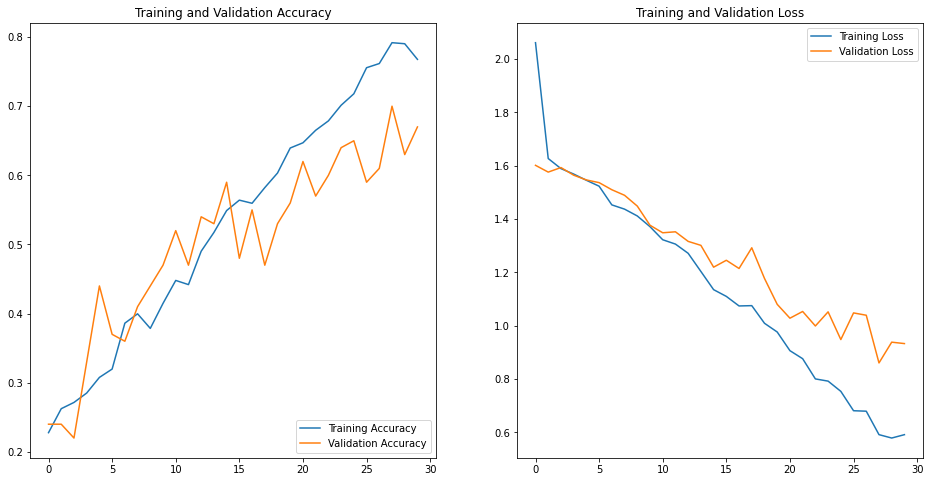

In [22]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

This model is performing very well as both validation and training accuracies are increasing steadily and the losses are also decreasing steadily. Also unlike Experiment 1, the number of parameters are much lower as well. 

It looks like it is not able to converge in 30 epochs so we shall try increasing speed with increasing batch size.

## Experiment 4: Increasing batch size

In [23]:
batch_size=64

In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:

optimiser = keras.optimizers.SGD() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 18, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 18, 120, 120, 8)   32        
_________________________________________________________________
activation_7 (Activation)    (None, 18, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 9, 60, 60, 8)      0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 9, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 9, 60, 60, 16)     64        
_________________________________________________________________
activation_8 (Activation)    (None, 9, 60, 60, 16)    

In [30]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.8893 - categorical_accuracy: 0.6983
Epoch 00001: val_loss did not improve from 0.72923
11/11 [==============================] - 73s 7s/step - loss: 0.8893 - categorical_accuracy: 0.6983 - val_loss: 1.1373 - val_categorical_accuracy: 0.5600
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.6297 - categorical_accuracy: 0.7783
Epoch 00002: val_loss did not improve from 0.72923
11/11 [==============================] - 69s 6s/step - loss: 0.6297 - categorical_accuracy: 0.7783 - val_loss: 0.9250 - val_categorical_accuracy: 0.6900
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.5683 - categorical_accuracy: 0.7858
Epoch 00003: val_loss did not improve from 0.72923
11/11 [==============================] - 68s 6s/step - loss: 0.5683 - categorical_accuracy: 0.7858 - val_loss: 0.9057 - val_categorical_accuracy: 0.6900
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 1.

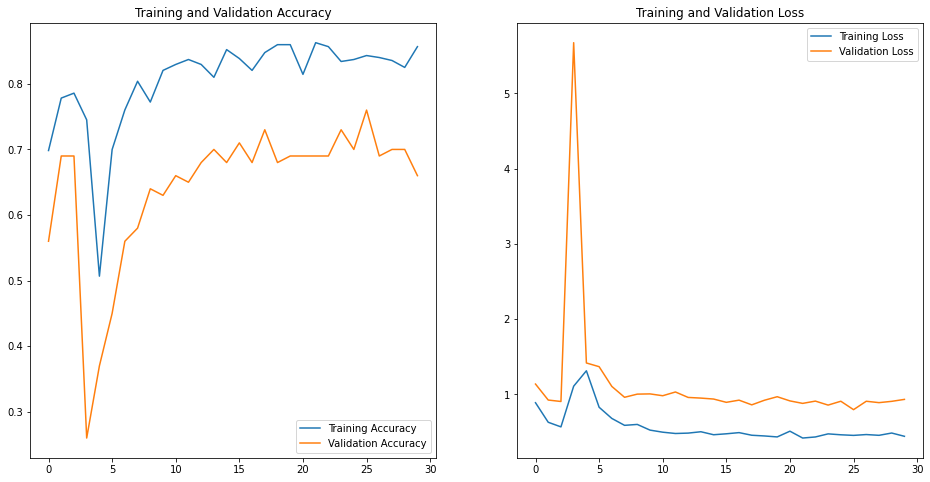

In [31]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

The training and validation accuracies both struggle in the beginning but start to increase very slowly later. We shall try increasing the learning rate as well and check if the model starts performing better



## Experiment 5: Increasing learning rate

In [ ]:
num_epochs = 30

In [ ]:
# Using SGD optimizer with LR=0.02 due to double batch size
optimiser = keras.optimizers.SGD(learning_rate=0.02) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [30]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.2525 - categorical_accuracy: 0.5430
Epoch 00001: val_loss did not improve from 0.80447
11/11 [==============================] - 98s 9s/step - loss: 1.2525 - categorical_accuracy: 0.5430 - val_loss: 1.2963 - val_categorical_accuracy: 0.4300
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.7490 - categorical_accuracy: 0.7360
Epoch 00002: val_loss did not improve from 0.80447
11/11 [==============================] - 96s 9s/step - loss: 0.7490 - categorical_accuracy: 0.7360 - val_loss: 1.0775 - val_categorical_accuracy: 0.6800
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.7056 - categorical_accuracy: 0.7421
Epoch 00003: val_loss did not improve from 0.80447
11/11 [==============================] - 108s 10s/step - loss: 0.7056 - categorical_accuracy: 0.7421 - val_loss: 1.0473 - val_categorical_accuracy: 0.5800
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 

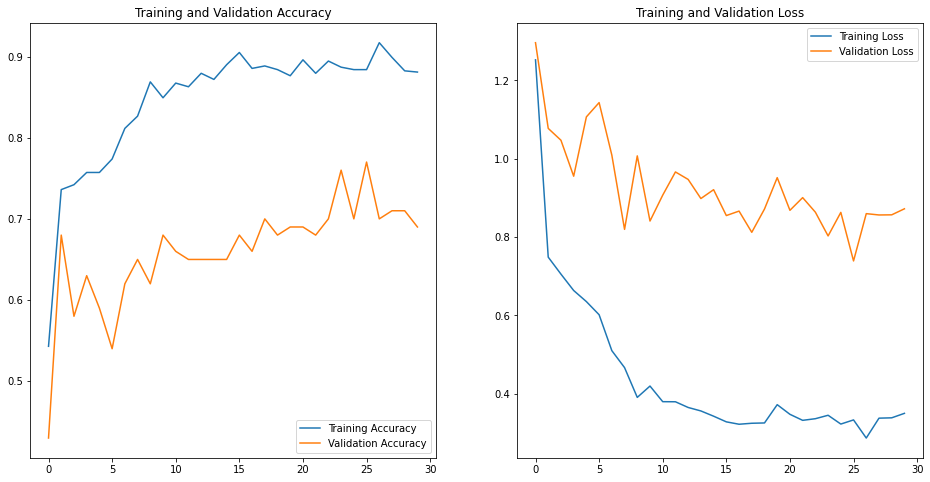

In [31]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

Increasing learning rate did not help acheieve the desired output. The model now overfits a lot. We shall try to increase the number of epochs of model and bring down the batch size to 32 and see if it is a better one

## Experiment 6: Increasing epochs to 40

In [32]:
num_epochs = 40

In [33]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [35]:
# Defining SGD optimizer with default LR=0.01
optimiser = keras.optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 18, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 120, 120, 8)   32        
_________________________________________________________________
activation_8 (Activation)    (None, 18, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 9, 60, 60, 8)      0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 9, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 60, 60, 16)     64        
_________________________________________________________________
activation_9 (Activation)    (None, 9, 60, 60, 16)   

In [36]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 1.9700 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.58735, saving model to model_init_cnn_2021-08-0217_36_00.885379/model-00001-1.96995-0.20664.h5
21/21 [==============================] - 72s 3s/step - loss: 1.9700 - categorical_accuracy: 0.2066 - val_loss: 1.5873 - val_categorical_accuracy: 0.3100
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 1.6339 - categorical_accuracy: 0.2504
Epoch 00002: val_loss improved from 1.58735 to 1.57550, saving model to model_init_cnn_2021-08-0217_36_00.885379/model-00002-1.63389-0.25038.h5
21/21 [==============================] - 72s 3s/step - loss: 1.6339 - categorical_accuracy: 0.2504 - val_loss: 1.5755 - val_categorical_accuracy: 0.4500
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 1.6125 - categorical_accuracy: 0.2775
Epoch 00003: val_loss did not improve from 1.57550
21/21 [==============================] - 

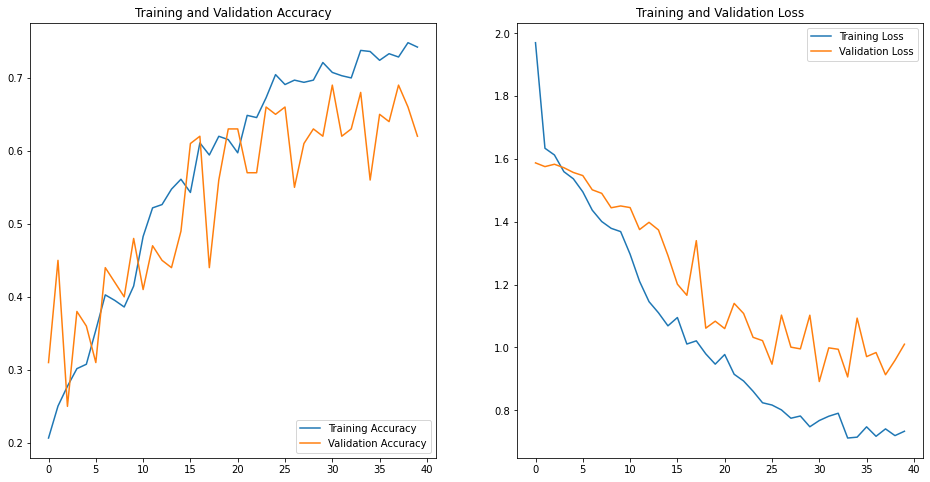

In [37]:
# Produce a graph for Accuracy and losses
plot_curves(history)

# CNN+RNN

We can also use another architecture of using CNN to extract features and RNN to process the extracted features in a time distributed fashion. This way we can acheieve a video processing NN. For this task, we can use pre-trained models and use the power of transfer learning. We shall choose MobileNetV2 CNN model since it is lightweight in nature which would suit the task in hand for application.

Since MobileNetV2 requires input to be processed in a specific format and shape we shall use preprocess_input() from keras mobilenet_v2 package and resize image to 128x128.

In [38]:
frame_width =128
frame_height=128

In [39]:
# using transfer learning so passing True 
train_generator = generator(train_path, train_doc, batch_size, True)
val_generator = generator(val_path, val_doc, batch_size, True)

In [40]:
model_name = 'model_init_gru' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

In [41]:
# Adding checkpoint Callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)
# Adding ReduceLR callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

## Experiment 7: CNN+RNN with MobileNetV2 Transfer Learning + GRU layers

In [42]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
    
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(24, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
# Disable trainability of layers in MobileNetV2
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(img_idx), 128, 128, 3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))

model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [43]:
# Compiling model with SGD optimizer with default LR of 0.01
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.build()
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 24)            2749528   
_________________________________________________________________
gru (GRU)                    (None, 18, 32)            5568      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 2,759,701
Trainable params: 501,717
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [44]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - 119s 6s/step - loss: 1.5943 - categorical_accuracy: 0.2549 - val_loss: 1.5604 - val_categorical_accuracy: 0.3100
Epoch 2/30
 8/21 [==========>...................] - ETA: 42s - loss: 1.5273 - categorical_accuracy: 0.3945
Epoch 00002: saving model to model_init_gru_2021-08-0214_39_13.403040/model-00002-1.52211-0.39931.h5
21/21 [==============================] - 105s 5s/step - loss: 1.4925 - categorical_accuracy: 0.4449 - val_loss: 1.5021 - val_categorical_accuracy: 0.4200
Epoch 3/30
17/21 [=======================>......] - ETA: 19s - loss: 1.3979 - categorical_accuracy: 0.5827
Epoch 00003: saving model to model_init_gru_2021-08-0214_39_13.403040/model-00003-1.39572-0.58854.h5
21/21 [==============================] - 133s 6s/step - loss: 1.3923 - categorical_accuracy: 0.5897 - val_loss: 1.4333 - val_categorical_accuracy: 0.5000
Epoch 4/30
21/21 [==============================] - 122s 6s/step - loss: 1.2836 - categorical_accuracy: 0.7330 

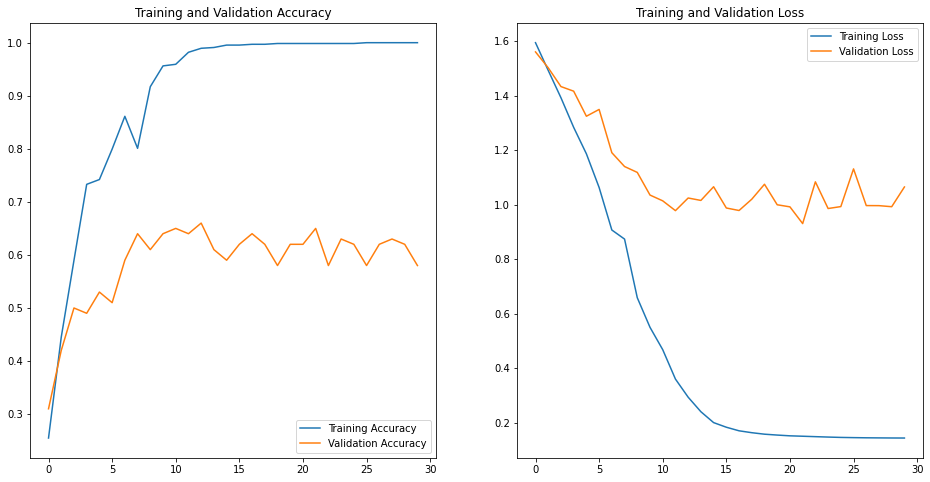

In [45]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

We can see that out model is overfitting since training accuracy is reaching  above 90% and validation accuracy is stagnant at 0.65. So we shall try adding dropout layer to mobilenetv2.

## Experiment 8: Decreasing the number of output neurons from MobileNet

In [46]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base_model.output
x = Flatten()(x)
# adding dropout for reducing neurons of MobileNet to combat oveerfitting
x = Dropout(0.5)(x)
# Adding dense layer of 24 kernels
features = Dense(24, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
# Disable trainability of layers in MobileNetV2
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(img_idx), 128, 128, 3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))

model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [47]:
# Compiling model with SGD optimizer with default LR of 0.01
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.build()
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 18, 24)            2749528   
_________________________________________________________________
gru_10 (GRU)                 (None, 18, 32)            5568      
_________________________________________________________________
gru_11 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 505       
Total params: 2,759,701
Trainable params: 501,717
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [48]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - 125s 6s/step - loss: 1.6005 - categorical_accuracy: 0.2534 - val_loss: 1.5461 - val_categorical_accuracy: 0.4100
Epoch 2/30
 8/21 [==========>...................] - ETA: 58s - loss: 1.5215 - categorical_accuracy: 0.4258 
Epoch 00002: saving model to model_init_gru_2021-08-0214_39_13.403040/model-00002-1.51777-0.42361.h5
21/21 [==============================] - 122s 6s/step - loss: 1.4981 - categorical_accuracy: 0.4585 - val_loss: 1.4495 - val_categorical_accuracy: 0.5500
Epoch 3/30
17/21 [=======================>......] - ETA: 20s - loss: 1.4000 - categorical_accuracy: 0.5607
Epoch 00003: saving model to model_init_gru_2021-08-0214_39_13.403040/model-00003-1.39771-0.56076.h5
21/21 [==============================] - 129s 6s/step - loss: 1.3866 - categorical_accuracy: 0.5777 - val_loss: 1.3946 - val_categorical_accuracy: 0.5400
Epoch 4/30
21/21 [==============================] - 94s 4s/step - loss: 1.2783 - categorical_accuracy: 0.6244 

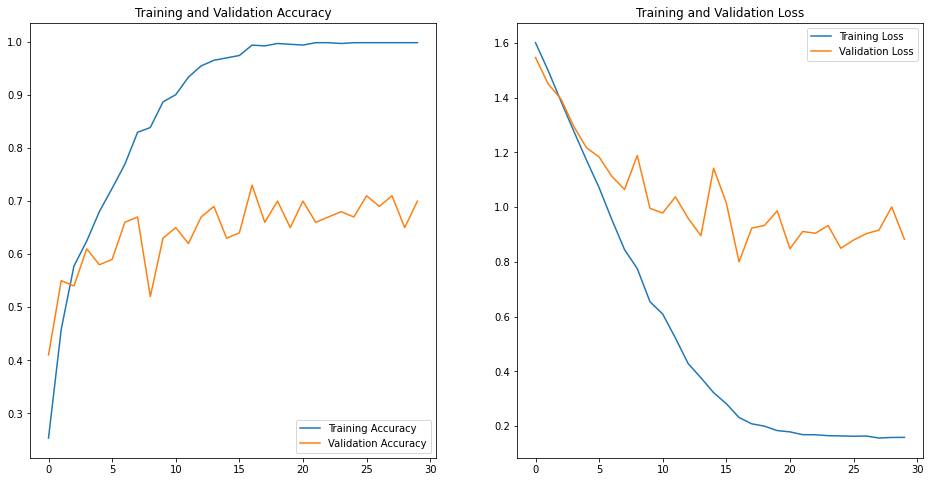

In [49]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

The model is still overfitting and there has been no improvement. We will now try combining multiple changes with some increase in parameters and some decrease. Also we shall tweak optimser as well

## Experiment 9: Decreasing batch size and learning rate, increasing GRU Kernels

In [50]:
batch_size = 16

In [51]:
# using transfer learning so passing True 
train_generator = generator(train_path, train_doc, batch_size, True)
val_generator = generator(val_path, val_doc, batch_size, True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [52]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base_model.output
x = Flatten()(x)
# Adding dense layer of 64 kernels
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
# Disable trainability of layers in MobileNetV2
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(img_idx), 128, 128, 3)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))

model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [53]:
# Compiling model with SGD optimizer with  LR of 0.001, decay of 0.00006 and momentum=0.7
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 18, 64)            3568768   
_________________________________________________________________
gru_16 (GRU)                 (None, 18, 64)            24960     
_________________________________________________________________
gru_17 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_25 (Dense)             (None, 1000)              33000     
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 5005      
Total params: 3,641,141
Trainable params: 1,383,157
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [54]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
18/42 [===========>..................] - ETA: 39s - loss: 1.6040 - categorical_accuracy: 0.1910
Epoch 00001: saving model to model_init_gru_2021-08-0214_39_13.403040/model-00001-1.60160-0.19737.h5
42/42 [==============================] - 83s 2s/step - loss: 1.5917 - categorical_accuracy: 0.2157 - val_loss: 1.5780 - val_categorical_accuracy: 0.2600
Epoch 2/30
 6/42 [===>..........................] - ETA: 49s - loss: 1.5676 - categorical_accuracy: 0.2812
Epoch 00002: saving model to model_init_gru_2021-08-0214_39_13.403040/model-00002-1.56371-0.29464.h5
36/42 [========================>.....] - ETA: 9s - loss: 1.5496 - categorical_accuracy: 0.3646 
Epoch 00002: saving model to model_init_gru_2021-08-0214_39_13.403040/model-00002-1.54928-0.35980.h5
42/42 [==============================] - 81s 2s/step - loss: 1.5479 - categorical_accuracy: 0.3695 - val_loss: 1.5486 - val_categorical_accuracy: 0.3600
Epoch 3/30
24/42 [================>.............] - ETA: 27s - loss: 1.5009 - cat

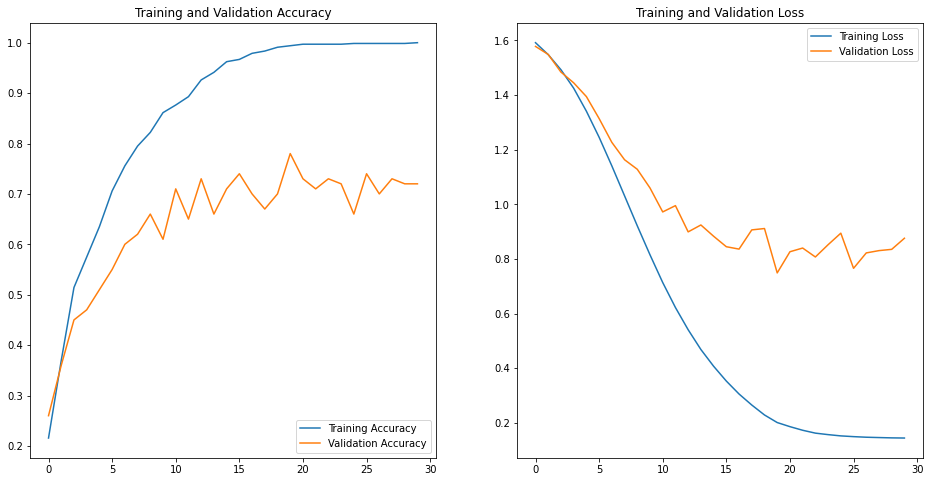

In [55]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

The model has a high tendency of overfitting. Adding dropouts and the learning rate reduction didnt help much. There is no improvement.

# Summary

The Experiment number 1 with CNN3D yield the best result in terms of training and validation accuracies.
Although there is further room for improvement which can be explored.